# Case study 1: Simulation with a SARS-CoV-2 Model

In [1]:
from IPython.display import Image

import eliater
from eliater.examples.sars_cov2 import sars_large_example as example
from y0.dsl import Variable

eliater.version_df()

,key,value
0,eliater,0.0.3-dev-b0c3d41b
1,y0,0.2.9-dev-06df659d
2,Run at,2024-01-28 19:36:52


In [2]:
treatment = Variable("EGFR")
outcome = Variable("cytok")
SEED = 10

This is case study 1 in Figure 6 in this paper: Eliater: an open source software for causal query estimation from observational measurements of biomolecular networks. The figure below shows the SARS-CoV-2 network (Mohammad-Taheri et al., 2022; Zucker
et al., 2021), which models the activation of Cytokine Release Syndrome (Cytokine Storm), a known factor causing tissue damage in severely ill SARS-CoV-2 patients (Ulhaq and Soraya, 2020).

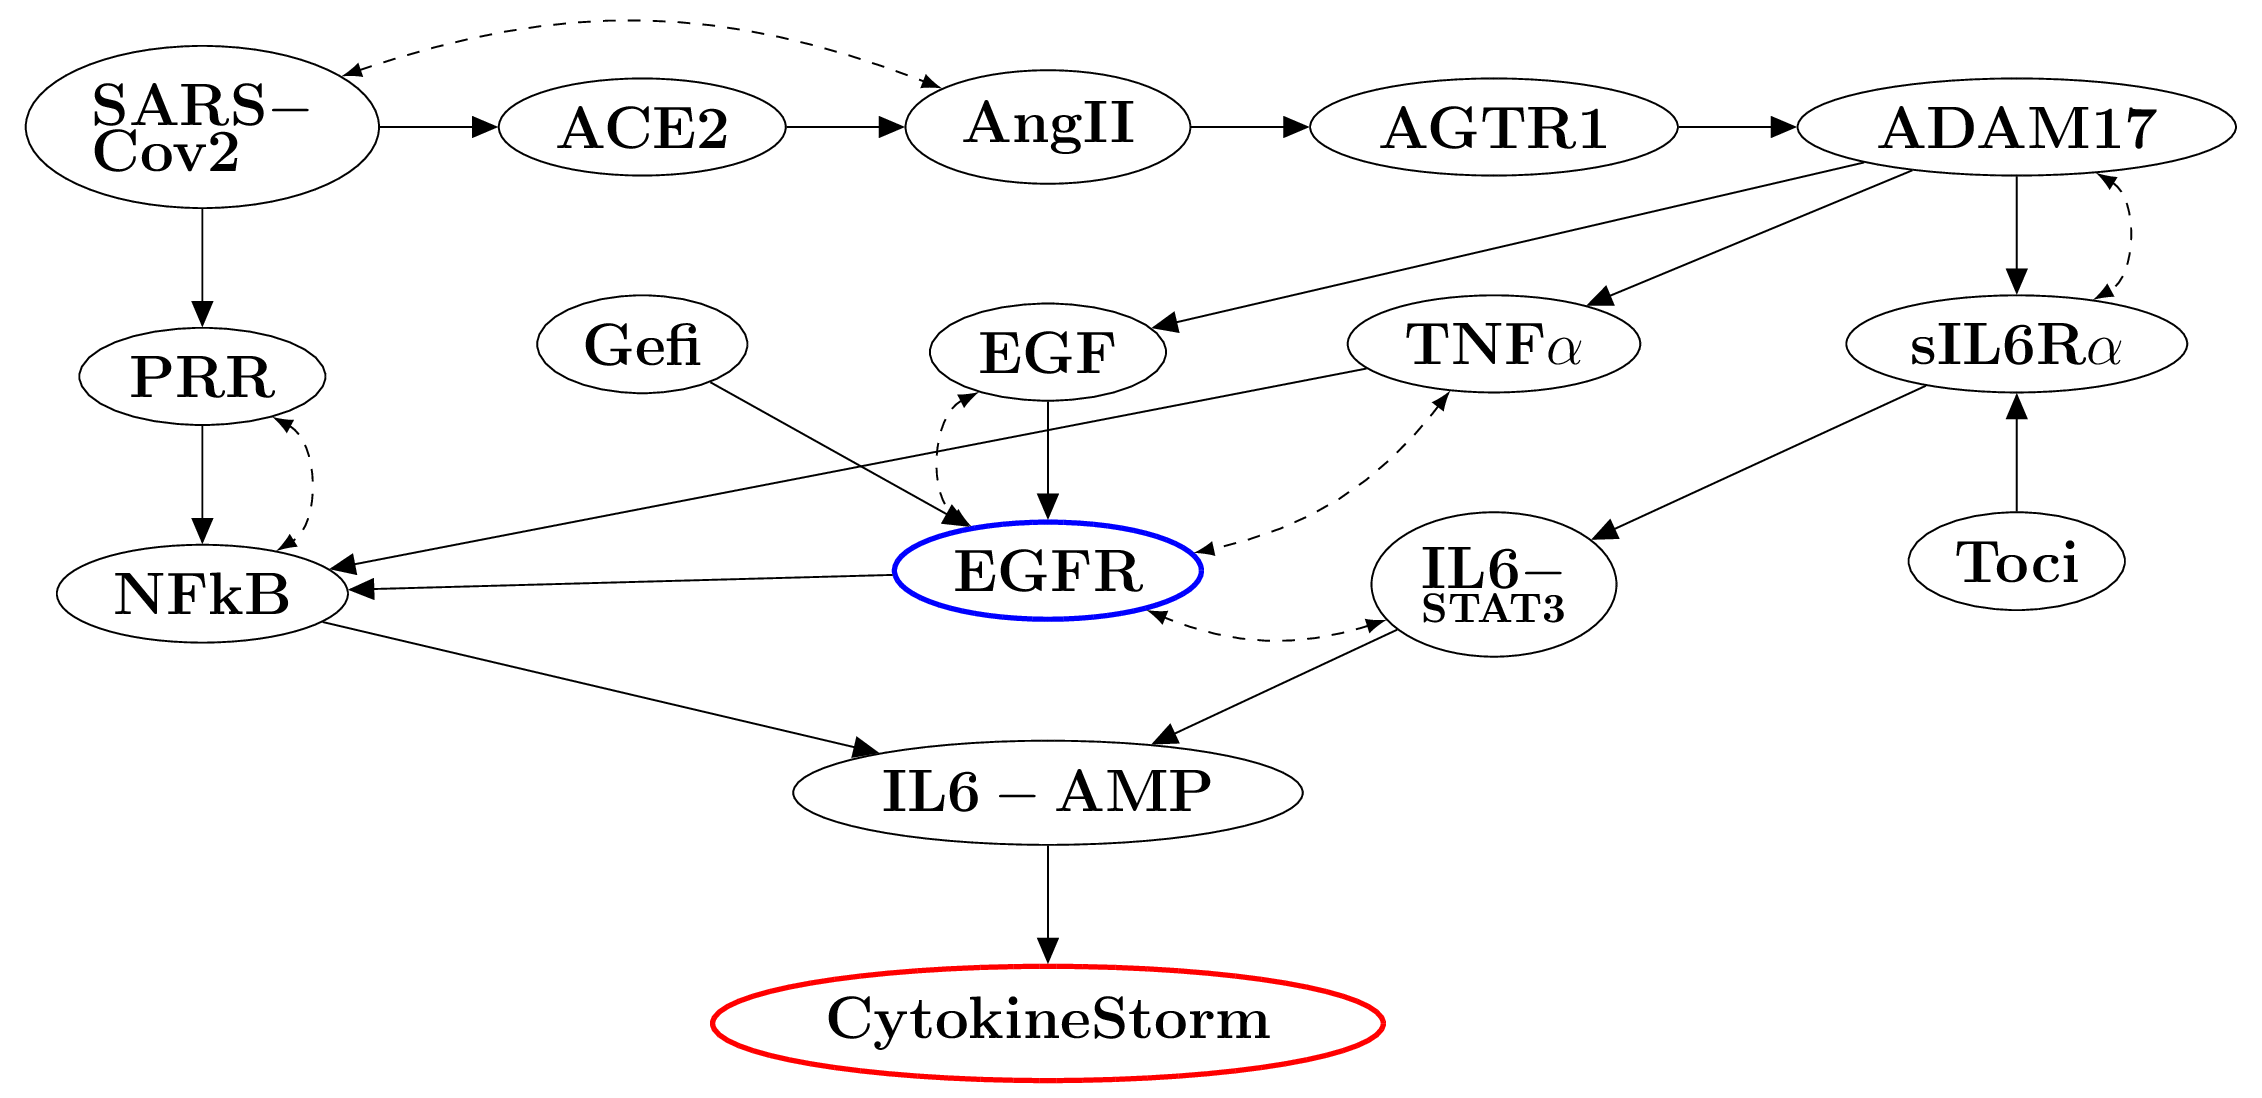

In [3]:
Image(filename="../img/SARS_COV.png", width=500, height=500)

In [4]:
graph = example.graph

This case study used synthetic observational data. The generation of this synthetic data was inspired by common biological practices.  The exogenous variables were modeled with a Gaussian distribution. For each endogenous variable $X$, we represented  biomolecular reactions using Hill equations \cite{alon2019introduction}, and were approximated with a sigmoid function as follows,

$\mathcal{N}(\frac{100}{1 + \exp(\mathbf{\theta}^{\prime} Pa(X) + \theta_0)})$ 

where $Pa(X)$ is a $q \times 1$ vector of measurements related to the parent of $X$, $\mathbf{\theta}'$ is a $1 \times q$ parameter vector, and $\theta_0$ is a scalar. The $EGFR$ was generated from a Binomial distribution with probability of $\frac{1}{1 + \exp(\mathbf{\theta}^{\prime} Pa(X) + \theta_0)}$. Hence, the observational data is mixed-type where the $EGFR$ column is binary (discrete), and rest of columns are continuous.

In [5]:
data = example.generate_data(1000, seed=SEED)
data.head()

,SARS_COV2,ACE2,Ang,AGTR1,ADAM17,Toci,Sil6r,EGF,TNF,Gefi,EGFR,PRR,NFKB,IL6STAT3,IL6AMP,cytok
0,74.818466,18.273505,94.393956,98.801910,99.256863,36.651069,85.881712,94.749073,99.863592,33.966616,1,99.518860,34.272531,33.312144,43.843032,67.926041
1,50.907438,36.711375,67.699182,99.294325,96.954993,52.899809,75.568726,94.950873,98.934965,37.749754,1,88.868626,32.037571,71.296943,69.477027,91.129469
2,76.434215,17.909068,94.771813,100.384201,100.226176,42.669583,87.432246,95.490495,99.403036,37.181947,1,96.605436,35.853639,59.013137,61.840728,85.813060
3,72.508174,19.305827,93.568645,99.296364,99.259188,46.082585,71.540865,96.506473,99.042601,47.669759,1,96.954760,39.201726,20.074860,35.928344,56.811495
4,63.747777,26.183989,87.636441,98.737421,99.825670,55.442630,86.093502,96.710827,100.583294,42.514193,1,94.118504,29.089479,41.607462,45.669105,69.531180


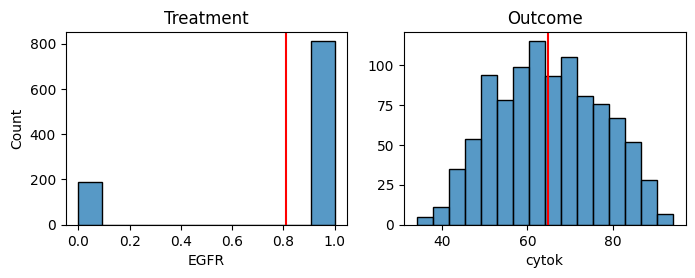

In [6]:
eliater.plot_treatment_and_outcome(data, treatment, outcome)

## Step 1: Verify correctness of the network structure

We checked the consistency of the network structure against observational data with significance level of 0.01 by first discretizing the data into a binary data and used the $\chi$-square test. This is because \texttt{Eliater} does not support mixed-type data.  

In [7]:
eliater.step_1_notebook(graph=graph, data=data, binarize=True)

## Step 1: Checking the ADMG Structure

On this try, we're going to discretize the data using K-Bins discretization with K as 2. Here are the first few rows of the transformed dataframe after doing that:

SARS_COV2,ACE2,Ang,AGTR1,ADAM17,Toci,Sil6r,EGF,TNF,Gefi,EGFR,PRR,NFKB,IL6STAT3,IL6AMP,cytok
1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0


Of the 99 d-separations implied by the network's structure, only 11 (11.11%) rejected the null hypothesis for the cressie_read test at p<0.01.

Since this is less than 30%, Eliater considers this minor and leaves the network unmodified. Finished in 7.88 seconds.


| left     | right     | given      |    stats |           p |   dof |       p_adj | p_adj_significant   |
|:---------|:----------|:-----------|---------:|------------:|------:|------------:|:--------------------|
| Ang      | PRR       | SARS_COV2  | 126.901  | 0           |     1 | 0           | True                |
| AGTR1    | PRR       | SARS_COV2  | 108.975  | 0           |     1 | 0           | True                |
| ADAM17   | PRR       | SARS_COV2  |  76.1544 | 0           |     1 | 0           | True                |
| ACE2     | PRR       | SARS_COV2  |  63.0893 | 1.9984e-15  |     1 | 1.91847e-13 | True                |
| Sil6r    | cytok     | IL6AMP     |  58.8112 | 1.73195e-14 |     1 | 1.64535e-12 | True                |
| IL6STAT3 | cytok     | IL6AMP     |  42.1103 | 8.62689e-11 |     1 | 8.10927e-09 | True                |
| Ang      | NFKB      | ADAM17;PRR |  34.944  | 3.39319e-09 |     1 | 3.15567e-07 | True                |
| NFKB     | SARS_COV2 | ADAM17;PRR |  29.5691 | 5.39582e-08 |     1 | 4.96415e-06 | True                |
| ACE2     | NFKB      | ADAM17;PRR |  27.0682 | 1.96399e-07 |     1 | 1.78723e-05 | True                |
| IL6STAT3 | Toci      | Sil6r      |  30.6843 | 2.1726e-07  |     2 | 1.95534e-05 | True                |
| Toci     | cytok     | IL6AMP     |  18.1308 | 2.0624e-05  |     1 | 0.00183554  | True                |

**Note** As the data was synthetically generated based on the network structure, we expected all the tests to pass. However, these failures might have been introduced by the discretization process.

In [8]:
eliater.step_2_notebook(graph=graph, treatment=treatment, outcome=outcome)


## Step 2: Check Query Identifiability

The causal query of interest is the average treatment effect of $EGFR$ on $cytok$, defined as: 
$\mathbb{E}[cytok \mid do(EGFR=1)] - \mathbb{E}[cytok \mid do(EGFR=0)]$.


Running the ID algorithm defined by [Identification of joint interventional distributions in recursive
semi-Markovian causal models](https://dl.acm.org/doi/10.5555/1597348.1597382) (Shpitser and Pearl, 2006)
and implemented in the $Y_0$ Causal Reasoning Engine gives the following estimand:

$\sum\limits_{ACE_2, ADAM_{17}, AGTR_1, Ang, IL6AM_P, IL6STA_{T3}, NFKB, PRR, SARS_COV_2, Sil6_r, TNF, Toci} P(ACE_2 | SARS_COV_2) P(AGTR_1 | ACE_2, Ang, SARS_COV_2) P(IL6AM_P | ACE_2, ADAM_{17}, AGTR_1, Ang, EGF, EGFR, Gefi, IL6STA_{T3}, NFKB, PRR, SARS_COV_2, Sil6_r, TNF, Toci) P(IL6STA_{T3} | ACE_2, ADAM_{17}, AGTR_1, Ang, SARS_COV_2, Sil6_r, Toci) P(TNF | ACE_2, ADAM_{17}, AGTR_1, Ang, SARS_COV_2) P(cytok | ACE_2, ADAM_{17}, AGTR_1, Ang, EGF, EGFR, Gefi, IL6AM_P, IL6STA_{T3}, NFKB, PRR, SARS_COV_2, Sil6_r, TNF, Toci) \sum\limits_{ACE_2, ADAM_{17}, AGTR_1, Ang, EGF, EGFR, Gefi, IL6AM_P, IL6STA_{T3}, NFKB, PRR, SARS_COV_2, Sil6_r, TNF, cytok} P(ACE_2, ADAM_{17}, AGTR_1, Ang, EGF, EGFR, Gefi, IL6AM_P, IL6STA_{T3}, NFKB, PRR, SARS_COV_2, Sil6_r, TNF, Toci, cytok) P(ADAM_{17} | ACE_2, AGTR_1, Ang, SARS_COV_2, Toci) P(Sil6_r | ACE_2, ADAM_{17}, AGTR_1, Ang, SARS_COV_2, Toci) P(Ang | ACE_2, SARS_COV_2) P(SARS_COV_2) P(NFKB | ACE_2, ADAM_{17}, AGTR_1, Ang, EGF, EGFR, Gefi, PRR, SARS_COV_2, TNF) P(PRR | ACE_2, Gefi, SARS_COV_2)$

Because the query is identifiable, we can proceed to Step 3.


In [9]:
identify_outcomes(graph=graph, treatments=treatment, outcomes=outcome)

NameError: name 'identify_outcomes' is not defined

The query is identifiable.

In [10]:
reduced_graph = eliater.step_3_notebook(graph=graph, treatment=treatment, outcome=outcome)

## Step 3/4: Identify Nuisance Variables and Simplify the ADMG

No variables were identified as nuisance variables.

Nevertheless, the algorithm proposed in [Graphs for margins of Bayesian
networks](https://arxiv.org/abs/1408.1809) (Evans, 2016) and implemented in
the $Y_0$ Causal Reasoning Engine is applied to the ADMG to attempt to
simplify the graph by reasoning over its bidirected edges (if they exist).


The simplification did not modify the graph.

## Evaluation criterion
As we used synthetic data set, we were able to generate two interventional data sets where in
one EGFR was set to 1, and the other one EGFR is set to 0. The ATE was calculated by subtracting the average value of Cytokine Storm obtained from each interventional data,
resulting in the ground truth ATE=0.796. The positive ATE indicates that the Gefitinib drug can not reduce the Cytokine Storm levels, hence can't help in treating patients having SARS-Cov-2.

In [11]:
eliater.step_5_notebook_synthetic(
    graph=graph,
    reduced_graph=reduced_graph,
    example=example,
    treatment=treatment,
    outcome=outcome,
    seed=SEED,
)

## Step 5: Estimate the Query

### Calculating the True Average Treatment Effect (ATE)

We first generated synthetic observational data. Now, we generate two interventional datasets:
one where we set $EGFR$ to $0.0$ and one where we set $EGFR$ to $1.0$.
We can then calculate the "true" average treatment effect (ATE) as the difference of the means
for the outcome variable $cytok$ in each. The ATE is formulated as:

$ATE = \mathbb{E}[cytok \mid do(EGFR = 1)] - \mathbb{E}[cytok \mid do(EGFR = 0)]$

After generating 10,000 samples for each distribution, we took 500 subsamples of size
of size 1,000 and calculated the
ATE for each. The variance comes to 2.0e-05, which shows that the ATE is very stable with respect
to random generation. We therefore calculate the _true_ ATE as the average value from these samplings,
which comes to 7.9e-01.

The ATE can be interpreted in the following way:

1. If the ATE is positive, it suggests that the treatment $EGFR$ has a negative effect on the outcome $cytok$
2. If the ATE is negative, it suggests that the treatment $EGFR$ has a positive effect on the outcome $cytok$

**Caveat**: Eliater does not yet implement a notion of confidence for the ATE. For example, it's not clear
where the cutoff for _significance_ is, and whether that is dataset- or ADMG-dependent.

### Estimating the Average Treatment Effect (ATE)

In practice, we are often unable to get the appropriate interventional data, and therefore want to estimate
the average treatment effect (ATE) from observational data. Because we're using synthetic data, we generate
10,000 samples, then took 500 subsamples of size 1,000 through which we calculated
the following:

1. The ATE, using the y0/ananke implementation
2. The ATE, using the Eliater linear regression implementation


Analyzing w/ subsampling:   0%|          | 0/500 [00:00<?, ?sample/s]

KeyboardInterrupt: 